In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp

from keras.activations import sigmoid
from keras.models import Model ,load_model
from keras.layers import Input, Dense, ConvLSTM2D, Conv2D, Conv1D, MaxPooling2D, Layer, GlobalAveragePooling2D, Reshape, Flatten, BatchNormalization, Bidirectional
from keras.regularizers import L2
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.optimizers.legacy import Adam
from keras.saving import register_keras_serializable
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from scipy.sparse.linalg import cg


2024-05-08 09:51:37.597105: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 09:51:37.616405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 09:51:37.616426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 09:51:37.616440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 09:51:37.620576: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU


2024-05-08 09:51:38.710579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 09:51:38.710677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 09:51:38.713304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# dirs
DATA_DIR = "./load.csv"

In [4]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')
data['Load'] = data['Load'] * 4


In [5]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [6]:
"""
The dataset columns must be the format below:

  index             Timestamp   Load
      0   20xx-xx-xx xx:xx:xx    xxx
      1                   ...    ...
      2                   ...    ...
                                 ...

"""

'\nThe dataset columns must be the format below:\n\n  index             Timestamp   Load\n      0   20xx-xx-xx xx:xx:xx    xxx\n      1                   ...    ...\n      2                   ...    ...\n                                 ...\n\n'

In [7]:
data

,Timestamp,Load
0,2023-01-01 00:00:00,0.445492
1,2023-01-01 00:15:00,0.427049
2,2023-01-01 00:30:00,0.445492
3,2023-01-01 00:45:00,0.420902
4,2023-01-01 01:00:00,0.422951
...,...,...
35035,2023-12-31 22:45:00,0.331148
35036,2023-12-31 23:00:00,0.270492
35037,2023-12-31 23:15:00,0.365574
35038,2023-12-31 23:30:00,0.337295


In [8]:
"""
!! parameter settings
n_predict: predict steps
height: final height of the image:
            height * 2 if the n_predict <= width,
            height * 2 + 1 if the n_predict > width
width: width of the image
n_days: use past n days historical time series data as input (number of channel)
n_window_shift: the shift interval of sliding window
"""
n_predict = 12
height = 4
width = 24
n_days_b = 3
n_days_s = 3
n_window_shift = "15min"

In [9]:
class TimeSeriesImageEncoder():
    def __init__(
            self,
        X: pd.DataFrame,
        n_predict: int,
        height: int,
        width: int,
        n_days_b: int,
        n_days_s: int,
        n_window_shift: str
    ) -> None:
        self.X = X
        self.h = height
        self.m = width
        self.d_b = n_days_b
        self.d_s = n_days_s
        self.shift = n_window_shift
        self.n_predict = n_predict
        self.Lb = self.h * self.m
        self.Ls = math.ceil(self.n_predict / self.m) * self.m
        self.timestamps = self.generate_timestamps()
        print(f"Lb: {self.Lb}")
        print(f"Ls: {self.Ls}")

    def generate_timestamps(self):
        start = self.X['Timestamp'].min() + DateOffset(days=self.d_b)
        end = self.X['Timestamp'].max() - DateOffset(minutes=self.n_predict*15)
        timestamps = pd.date_range(start=start, end=end, freq=self.shift)
        return timestamps
    
    def generate_gaussian_noise(self, length, std_dev=0.15):
        noise = np.random.normal(loc=0.5, scale=std_dev, size=length)
        noise = np.clip(noise, 0, 1)
        # noise = np.zeros(shape=length)
        return pd.DataFrame({"Load": noise})
    
    def make_it_symmetric_3d(self, sets_3d):
        symmetry_training_sets = []
        for slice_2d in np.array(sets_3d):
            reversed_slice_2d = slice_2d[::-1]
            combined_slice_2d = np.concatenate((slice_2d, reversed_slice_2d), axis=0)
            symmetry_training_sets.append(combined_slice_2d)
        return np.array(symmetry_training_sets)
    
    def make_it_symmetric_2d(self, sets_2d):
        reversed_slice_2d = sets_2d[::-1]
        combined_slice_2d = np.concatenate((sets_2d, reversed_slice_2d), axis=0)
        return np.array(combined_slice_2d)
    

    def encode_b(self):
        training_sets = []
        target_sets = []
        self.X_timeseries_flatten = []
        self.X_timestamp = []
        self.y_timestamp = []
        for steps in self.timestamps:
            training_start_b = steps - DateOffset(days=self.d_b-1, hours=23, minutes=45)
            training_end = steps
            target_start = training_end + DateOffset(minutes=15)
            target_end = steps + DateOffset(minutes=(self.n_predict)*15)
            # noise = self.generate_gaussian_noise(length=self.n_predict)
            training_data = self.X[(self.X['Timestamp'] >= training_start_b) & (self.X['Timestamp'] <= training_end)]
            # training_data = pd.concat([training_data, noise], ignore_index=True)
            target_data = self.X[(self.X['Timestamp'] >= target_start) & (self.X['Timestamp'] <= target_end)]
            if not training_data.empty and not target_data.empty:
                self.X_timeseries_flatten.append(training_data['Load'])
                self.X_timestamp.append(training_data['Timestamp'])
                self.y_timestamp.append(target_data['Timestamp'])
                training_reshaped = np.array(training_data['Load']).reshape(self.d_b, self.h, self.m)
                symmetric_3d = self.make_it_symmetric_3d(training_reshaped)
                training_sets.append(symmetric_3d)
                target_reshaped = np.array(target_data['Load']).reshape(math.ceil(self.n_predict/self.m), min(self.n_predict, self.m))
                symmetric_2d = self.make_it_symmetric_2d(target_reshaped)
                target_sets.append(symmetric_2d)
        training_sets = np.array(training_sets)
        target_sets = np.array(target_sets)

        self.X_timeseries_flatten = np.array(self.X_timeseries_flatten)
        self.X_timestamp = np.array(self.X_timestamp)
        self.y_timestamp = np.array(self.y_timestamp)
        return training_sets, target_sets
    
    # def encode_s(self):
    #     training_sets = []
    #     for steps in self.timestamps:
    #         training_subset = []
    #         point = steps - DateOffset(days=self.d_s-1)
    #         training_start = point - DateOffset(minutes=(self.m-1)*15)
    #         # training
    #         for _ in range(self.d_s-1):
    #             training_end = training_start + DateOffset(minutes=(self.m-1)*15)
    #             training_data = self.X[(self.X['Timestamp'] >= training_start) & (self.X['Timestamp'] <= training_end)]
    #             if not training_data.empty:
    #                 symmetric_2d = self.make_it_symmetric_2d(training_data['Load'])
    #                 training_subset.append(symmetric_2d)
    #             training_start = training_start + DateOffset(days=1)
    #         training_end = training_start + DateOffset(minutes=(self.m-self.n_predict-1)*15)
    #         training_data = self.X[(self.X['Timestamp'] >= training_start) & (self.X['Timestamp'] <= training_end)]
    #         noise = self.generate_gaussian_noise(length=self.n_predict)
    #         training_data = pd.concat([training_data, noise], ignore_index=True)
    #         symmetric_2d = self.make_it_symmetric_2d(training_data['Load'])
    #         training_subset.append(symmetric_2d)
    #         training_sets.append(training_subset)
    #     training_sets = np.array(training_sets)
    #     return training_sets
    
    def encode(self):
        training_sets_b, target_sets = self.encode_b()
        # training_sets_s = self.encode_s()
        training_sets_b = np.transpose(training_sets_b, (0, 2, 3, 1))
        # training_sets_s = np.transpose(training_sets_s, (0, 2, 3, 1))
        return training_sets_b, target_sets

In [10]:
encoder = TimeSeriesImageEncoder(
    X=data,
    n_predict=n_predict,
    height=height,
    width=width,
    n_days_b=n_days_b,
    n_days_s=n_days_s,
    n_window_shift=n_window_shift
)
encoded_Xb, encoded_y = encoder.encode()
X_timeseries = np.copy(encoder.X_timeseries_flatten)
X_timestamp = np.copy(encoder.X_timestamp)
y_timestamp = np.copy(encoder.y_timestamp)

Lb: 96
Ls: 24


In [11]:
print(encoded_Xb.shape)
print(encoded_y.shape)

print(X_timeseries.shape)
print(X_timestamp.shape)
print(y_timestamp.shape)

(34740, 8, 24, 3)
(34740, 2, 12)
(34740, 288)
(34740, 288)
(34740, 12)


In [12]:
MONTH_TIME_STEP = math.floor(encoder.timestamps.shape[0] / 24)
X_test_b = []
y_test = []
X_test_b_flatten = []
X_test_b_timestamp = []
y_test_timestamp = []

for i in range(0, 24):
    start = (i+1)*MONTH_TIME_STEP-(192*(i+1))
    end = (i+1)*MONTH_TIME_STEP-(192*i)
    X_test_b.append(encoded_Xb[start:end])
    y_test.append(encoded_y[start:end])
    X_test_b_flatten.append(X_timeseries[start:end])
    X_test_b_timestamp.append(X_timestamp[start:end])
    y_test_timestamp.append(y_timestamp[start:end])


    encoded_Xb = np.concatenate([encoded_Xb[:start], encoded_Xb[end:]])
    encoded_y = np.concatenate([encoded_y[:start], encoded_y[end:]])
    X_timeseries = np.concatenate([X_timeseries[:start], X_timeseries[end:]])
    X_timestamp = np.concatenate([X_timestamp[:start], X_timestamp[end:]])
    y_timestamp = np.concatenate([y_timestamp[:start], y_timestamp[end:]])


In [13]:
X_test_b = np.concatenate([i for i in X_test_b])
y_test = np.concatenate([i for i in y_test])
X_test_b_flatten = np.concatenate([i for i in X_test_b_flatten])
X_test_b_timestamp = np.concatenate([i for i in X_test_b_timestamp])
y_test_timestamp = np.concatenate([i for i in y_test_timestamp])


In [14]:
X_train_b = encoded_Xb
y_train = encoded_y

In [15]:
print(np.array(X_train_b).shape)
print(np.array(X_test_b).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)
print(X_test_b_flatten.shape)
print(X_test_b_timestamp.shape)
print(y_test_timestamp.shape)

(30132, 8, 24, 3)
(4608, 8, 24, 3)
(30132, 2, 12)
(4608, 2, 12)
(4608, 288)
(4608, 288)
(4608, 12)


In [16]:
@register_keras_serializable('ECALayer')
class ECALayer(Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        c = input_shape[-1]
        self.t = max(1, int(abs((tf.math.log(float(c)) / tf.math.log(2.0) + self.b) / self.gamma)))
        self.conv = Conv1D(filters=1, kernel_size=self.t, padding='same', use_bias=False)
        super(ECALayer, self).build(input_shape)

    def call(self, inputs):
        # Global Average Pooling over the spatial dimensions to produce a (batch_size, 1, channels) tensor
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, -1))(x)
        x = self.conv(x)
        x = sigmoid(x)
        x = tf.squeeze(x, axis=1)  # Squeeze to make it (batch_size, channels)
        
        # Multiply weights across channels
        return inputs * x[:, tf.newaxis, tf.newaxis, :]

    def get_config(self):
        config = super(ECALayer, self).get_config()
        config.update({
            'gamma': self.gamma,
            'b': self.b
        })
        return config

In [17]:
@register_keras_serializable('AverageLayer')
class AverageLayer(Layer):
    def __init__(self, **kwargs):
        super(AverageLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return (inputs[0] + inputs[1]) / 2

In [18]:
# def create_model(input_shape_b, input_shape_s, num_outputs):
#     inputs_b = Input(shape=input_shape_b)
#     inputs_s = Input(shape=input_shape_s)
#     conv1 = Conv2D(filters=32, kernel_size=8, padding="same", activation="tanh")(inputs_b)
#     conv2 = Conv2D(filters=64, kernel_size=8, padding="same", activation="tanh")(conv1)
#     conv2 = Reshape((1, *conv2.shape[1:]))(conv2)  
#     lstm1 = ConvLSTM2D(filters=96, kernel_size=8, padding="same", activation="tanh", return_sequences=True, dropout=0.3)(conv2)
#     lstm2 = ConvLSTM2D(filters=96, kernel_size=8, padding="same", activation="tanh", return_sequences=False, dropout=0.3)(lstm1)
#     eca1 = ECALayer()(lstm2)
#     conv3 = Conv2D(filters=64, kernel_size=8, padding="same", activation="tanh")(eca1)
#     conv4 = Conv2D(filters=32, kernel_size=8, padding="same", activation="tanh")(conv3)
#     maxpool1 = MaxPooling2D(pool_size=10, padding="same")(conv4)
#     flatten1 = Flatten()(maxpool1)
#     dense1 = Dense(2*num_outputs, activation="linear")(flatten1)
#     outputs1 = Reshape((2, 12))(dense1)

#     conv5 = Conv2D(filters=8, kernel_size=2, padding="same", activation="tanh")(inputs_s)
#     conv6 = Conv2D(filters=16, kernel_size=2, padding="same", activation="tanh")(conv5)
#     conv6 = Reshape((1, *conv6.shape[1:]))(conv6)  
#     lstm3 = ConvLSTM2D(filters=24, kernel_size=2, padding="same", activation="tanh", return_sequences=True, dropout=0.3)(conv6)
#     lstm4 = ConvLSTM2D(filters=24, kernel_size=2, padding="same", activation="tanh", return_sequences=False, dropout=0.3)(lstm3)
#     eca2 = ECALayer()(lstm4)
#     conv7 = Conv2D(filters=16, kernel_size=2, padding="same", activation="tanh")(eca2)
#     conv8 = Conv2D(filters=8, kernel_size=2, padding="same", activation="tanh")(conv7)
#     maxpool2 = MaxPooling2D(pool_size=5, padding="same")(conv8)
#     flatten2 = Flatten()(maxpool2)
#     dense2 = Dense(2*num_outputs, activation="linear")(flatten2)
#     outputs2 = Reshape((2, 12))(dense2)

#     final_output = AverageLayer()([outputs1, outputs2])
#     model = Model(inputs=[inputs_b, inputs_s], outputs=final_output)

#     return model


In [19]:
def create_model(input_shape_b, encoder):
    height, width = math.ceil(encoder.n_predict / encoder.m) * 2, min(encoder.n_predict, encoder.m)
    inputs_b = Input(shape=input_shape_b)
    conv1 = Conv2D(filters=32, kernel_size=3, padding="same", activation="tanh")(inputs_b)
    conv2 = Conv2D(filters=64, kernel_size=3, padding="same", activation="tanh")(conv1)
    conv2 = Reshape((1, *conv2.shape[1:]))(conv2)
    nor1 = BatchNormalization()(conv2)
    lstm1 = Bidirectional(ConvLSTM2D(filters=96, kernel_size=3, padding="same", activation="tanh", return_sequences=True, dropout=0.0))(nor1)
    nor2 = BatchNormalization()(lstm1)
    lstm2 = Bidirectional(ConvLSTM2D(filters=96, kernel_size=3, padding="same", activation="tanh", return_sequences=False, dropout=0.0))(nor2)
    nor3 = BatchNormalization()(lstm2)
    eca1 = ECALayer()(nor3)
    nor4 = BatchNormalization()(eca1)
    conv3 = Conv2D(filters=64, kernel_size=3, padding="same", activation="tanh")(nor4)
    conv4 = Conv2D(filters=32, kernel_size=3, padding="same", activation="tanh")(conv3)
    nor5 = BatchNormalization()(conv4)
    maxpool1 = MaxPooling2D(pool_size=10, padding="same")(nor5)
    flatten1 = Flatten()(maxpool1)
    dense1 = Dense(height*width, activation="linear")(flatten1)
    outputs = Reshape((height, width))(dense1)
    model = Model(inputs=inputs_b, outputs=outputs)

    return model

In [20]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%load_ext tensorboard

tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
early_stopping_callback = EarlyStopping(monitor="loss", patience=10, min_delta=5e-5)
reduce_lr_callback = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=5, verbose=1, min_lr=1e-7)
callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback]
model = create_model(input_shape_b=X_train_b.shape[1:], encoder=encoder)
model.compile(optimizer=Adam(learning_rate=5e-5), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 24, 3)]        0         
                                                                 
 conv2d (Conv2D)             (None, 8, 24, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 24, 64)         18496     
                                                                 
 reshape (Reshape)           (None, 1, 8, 24, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 1, 8, 24, 64)      256       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 1, 8, 24, 192)     1106688   
 al)                                                         

In [21]:
def apply_lbfgs(model, loss_fn, x_data, y_data, learning_rate_theta=1e-5):
    # flatten model parameters theta to 1-dim array
    initial_params = tf.concat([tf.reshape(param, [-1]) for param in model.trainable_variables], axis=0)

    # define a function to calculate loss and gradient
    def value_and_gradients_function(params):
        # update model parameter theta
        assign_new_model_parameters(model, params)
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            predictions = model(x_data, training=True)
            loss = loss_fn(y_data, predictions)
        # calculate the loss gradient w.r.t model parameters theta
        grads = tape.gradient(loss, model.trainable_variables)
        flat_grads = tf.concat([tf.reshape(grad, [-1]) for grad in grads], axis=0)
        return loss, flat_grads

    # execute L-BFGS optimization
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function,
        initial_position=initial_params,
        tolerance=1e-8  # adjust to appropriate training tolerance
    )

    # assign new model parameter theta
    assign_new_model_parameters(model, results.position)

def assign_new_model_parameters(model, flat_params):
    """ Update model parameter theta """
    start = 0
    for param in model.trainable_variables:
        size = tf.size(param)
        new_shape = tf.shape(param)
        param.assign(tf.reshape(flat_params[start:start + size], new_shape))
        start += size

def update_weights(model, X_val, y_val, weights, learning_rate_w):
    """ Update the weight of the sample """
    with tf.GradientTape() as tape:
        tape.watch(weights)
        predictions = model(X_val, training=True)
        loss = tf.reduce_mean(weights * tf.keras.losses.mean_squared_error(y_val[:, 0], tf.reduce_mean(predictions, axis=1, keepdims=True)))
    grads = tape.gradient(loss, weights)
    new_weights = tf.clip_by_value(weights - learning_rate_w * grads, 1e-5, 1)
    return new_weights

def training(model, X_train, y_train, X_val, y_val, epochs, batch_size, callbacks):
    for callback in callbacks:
        callback.set_model(model)
        callback.on_train_begin()
        
    weights = tf.Variable(np.ones(len(X_train)) / len(X_train), dtype=tf.float32)
    # learning rate of the sample weight
    learning_rate_w = 5e-5
    # learning rate of the model parameters θ
    learning_rate_theta = 1e-5
    # optimizer of model parameters θ
    optimizer_theta = Adam(learning_rate=learning_rate_theta)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        for callback in callbacks:
            callback.on_epoch_begin(epoch)

        for batch in range((len(X_train) + batch_size - 1) // batch_size):
            start = batch * batch_size
            end = min(start + batch_size, len(X_train))

            apply_lbfgs(model, lambda y_true, y_pred: tf.reduce_mean(weights[start:end] * tf.keras.losses.mean_squared_error(y_true[:, 0], tf.reduce_mean(y_pred, axis=1, keepdims=True))), X_train[start:end], y_train[start:end])
        
        weights.assign(update_weights(model, X_val, y_val, weights, learning_rate_w=learning_rate_w))

        predictions = model(X_train, training=True)
        val_loss = tf.reduce_mean(weights * tf.keras.losses.mean_squared_error(y_train[:, 0], tf.reduce_mean(predictions, axis=1, keepdims=True)))
        print(f"val_loss: {val_loss.numpy()}")
        
        if early_stopping_callback.stopped_epoch:
            print("Early stopping triggered")
            break
    
    for callback in callbacks:
        callback.on_train_end()


In [22]:
history = model.fit(
    X_train_b,
    y_train,
    verbose=1,
    epochs=120,
    batch_size=96,
    callbacks=[tensorboard_callback, early_stopping_callback, reduce_lr_callback]
)
 


Epoch 1/120


2024-05-08 09:52:04.852396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


314/314 [==============================] - 21s 54ms/step - loss: 0.4068 - lr: 5.0000e-05
Epoch 2/120
314/314 [==============================] - 16s 52ms/step - loss: 0.0193 - lr: 5.0000e-05
Epoch 3/120
314/314 [==============================] - 17s 53ms/step - loss: 0.0133 - lr: 5.0000e-05
Epoch 4/120
314/314 [==============================] - 17s 55ms/step - loss: 0.0109 - lr: 5.0000e-05
Epoch 5/120
314/314 [==============================] - 17s 55ms/step - loss: 0.0095 - lr: 5.0000e-05
Epoch 6/120
314/314 [==============================] - 17s 55ms/step - loss: 0.0085 - lr: 5.0000e-05
Epoch 7/120
314/314 [==============================] - 18s 56ms/step - loss: 0.0079 - lr: 5.0000e-05
Epoch 8/120
314/314 [==============================] - 18s 56ms/step - loss: 0.0073 - lr: 5.0000e-05
Epoch 9/120
314/314 [==============================] - 17s 56ms/step - loss: 0.0068 - lr: 5.0000e-05
Epoch 10/120
314/314 [==============================] - 18s 56ms/step - loss: 0.0064 - lr: 5.0000e-05
E

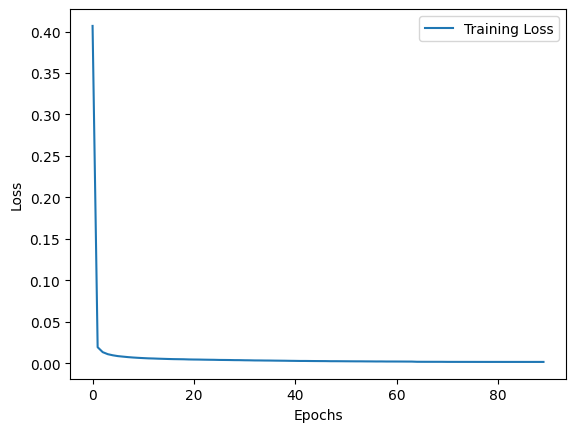

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict([X_test_b])

  1/144 [..............................] - ETA: 1:01

2024-05-08 10:17:38.352126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/mul_2' -> 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/add_5', 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/Tanh_1' -> 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/mul_5', 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/convolution_7' -> 'model/bidirectional_1/forward_conv_lstm2d_1/while/body/_97/model/bidirectional_1/forward_conv_lstm2d_1/while/add_6', 'Func/model/bidirectional_1/backward_conv_lstm2d_1/while/body/_145/input/_32

144/144 [==============================] - 2s 8ms/step


In [25]:
def sum_np(matrix):
    # Calculate the number of pairs
    n_pairs = len(matrix) // 2
    
    # Initialize a list to hold the sums
    sums = []
    
    # Iterate through pairs of rows: first-last, second-second last, etc.
    for i in range(n_pairs):
        sums.append(list(map(sum, zip(matrix[i], matrix[-(i + 1)]))))
        
    # If there's an odd number of rows, include the middle row
    if len(matrix) % 2 != 0:
        sums.append(matrix[n_pairs])
    
    # Flatten the resulting list of sums
    return [num for row in sums for num in row]

def pairwise_sum(matrix):
    summed_3d_np = np.array([sum_np(layer) for layer in matrix]) / 2
    return summed_3d_np

In [26]:
y_pred_final = pairwise_sum(y_pred)
y_test_final = pairwise_sum(y_test)

In [27]:
print(y_test_final.shape)
print(y_pred_final.shape)
mse = mean_squared_error(y_test_final, y_pred_final)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_final, y_pred_final)
r2 = r2_score(y_test_final, y_pred_final)
print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'rmse: {rmse:.4f}')
print(f'mae: {mae:.4f}')
print(f'r2: {r2:.4f}')
print("-" * 86)

(4608, 12)
(4608, 12)
--------------------------------------------------------------------------------------
mse: 0.0040
rmse: 0.0632
mae: 0.0427
r2: 0.8362
--------------------------------------------------------------------------------------


In [28]:
TEST_PLOT_DIR = "./test_plots/image_inpainting_bidirectional_nn/"

In [29]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")

In [30]:
pred_data = scaler.inverse_transform(y_pred_final)
actual_data = scaler.inverse_transform(y_test_final)
previous_data = scaler.inverse_transform(X_test_b_flatten)
for i in range(actual_data.shape[0]):
    plt.figure(figsize=(12, 6))
    X1 = np.concatenate((X_test_b_timestamp[i][-30:], y_test_timestamp[i]))
    y1 = np.concatenate((previous_data[i][-30:], actual_data[i]))
    X2 = y_test_timestamp[i]
    y_p = pred_data[i]
    y_a = actual_data[i]
    Xh = np.full(100, X1[len(X1)-12])
    yh = np.arange(0, 100, 1)
    plt.title(f"Time Series {i+1} prediction")
    plt.plot(X1, y1, '--', color='#98afc7')
    plt.plot(X2, y_p, label='Predict')
    plt.plot(X2, y_a, label='Actual')
    plt.scatter(X2, y_p)
    plt.scatter(X2, y_a)
    plt.plot(Xh, yh, color='#4863a0', alpha=0.5)
    plt.ylim(0, 100)
    plt.xlabel('Time step')
    plt.ylabel('Usage (kWh)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(TEST_PLOT_DIR+f"Time_Series_{i+1}.png")
    plt.close()

In [31]:
model.save("./model/image_inpainting_CNN_LSTM.keras")